## Image segmentation of Synthetic Unity data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = Path('/root/workspace/AI/ImageSynthData/captures')
path.ls()

[PosixPath('/root/workspace/AI/ImageSynthData/captures/train'),
 PosixPath('/root/workspace/AI/ImageSynthData/captures/val')]

## Data

In [4]:
fnames = list((path/'train').glob('*img*'))
fnames[:3]

[PosixPath('/root/workspace/AI/ImageSynthData/captures/train/image_00296_img.png'),
 PosixPath('/root/workspace/AI/ImageSynthData/captures/train/image_01025_img.png'),
 PosixPath('/root/workspace/AI/ImageSynthData/captures/train/image_01043_img.png')]

In [5]:
lbl_names = list((path/'train').glob('*layer*'))
lbl_names[:3]

[PosixPath('/root/workspace/AI/ImageSynthData/captures/train/image_00002_layer.png'),
 PosixPath('/root/workspace/AI/ImageSynthData/captures/train/image_00354_layer.png'),
 PosixPath('/root/workspace/AI/ImageSynthData/captures/train/image_01210_layer.png')]

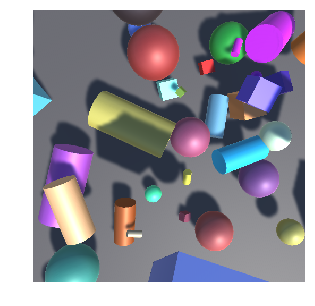

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
get_y_fn = lambda x: str(x).replace('img', 'layer')

In [8]:
open_image(get_y_fn(img_f), convert_mode='L').data.unique()

tensor([0.0314, 0.0392, 0.0196, 0.0353, 0.0157, 0.0000])

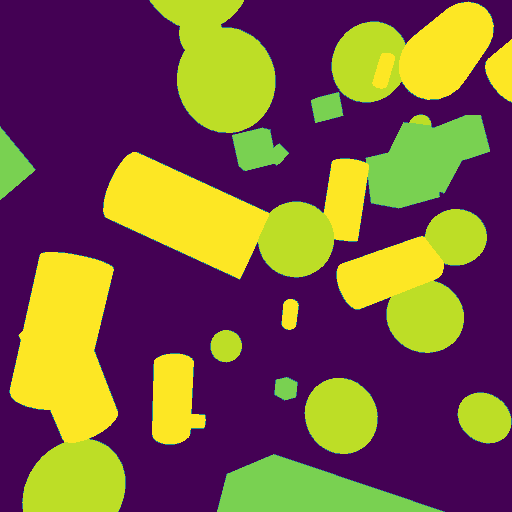

In [9]:
mask = open_mask(get_y_fn(img_f))
mask

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([512, 512]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [11]:
codes = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "Cube", "Sphere", "Cylinder"])

## Datasets

In [12]:
size = src_size//2
bs=8

In [13]:
def just_images(x):
    return 'img' in str(x)

src = (SegmentationItemList.from_folder(path)
     .filter_by_func(just_images)
     .split_by_folder(train='train', valid='val')
     .label_from_func(get_y_fn, classes=codes))
src

LabelLists;

Train: LabelList
y: SegmentationLabelList (1999 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: /root/workspace/AI/ImageSynthData/captures
x: SegmentationItemList (1999 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /root/workspace/AI/ImageSynthData/captures;

Valid: LabelList
y: SegmentationLabelList (400 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: /root/workspace/AI/ImageSynthData/captures
x: SegmentationItemList (400 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /root/workspace/AI/ImageSynthData/captures;

Test: None

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

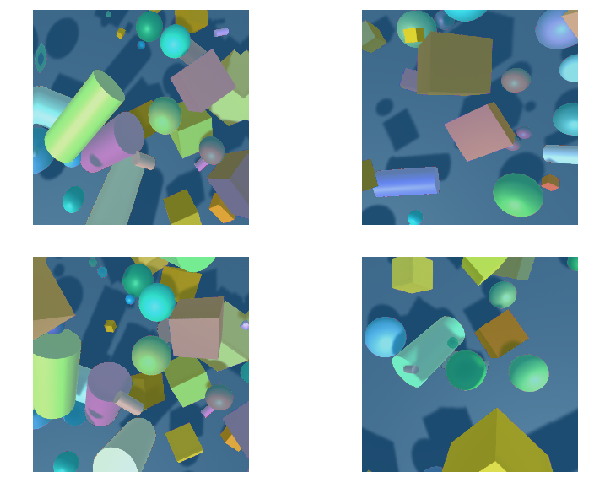

In [15]:
data.show_batch(2, figsize=(10,7))

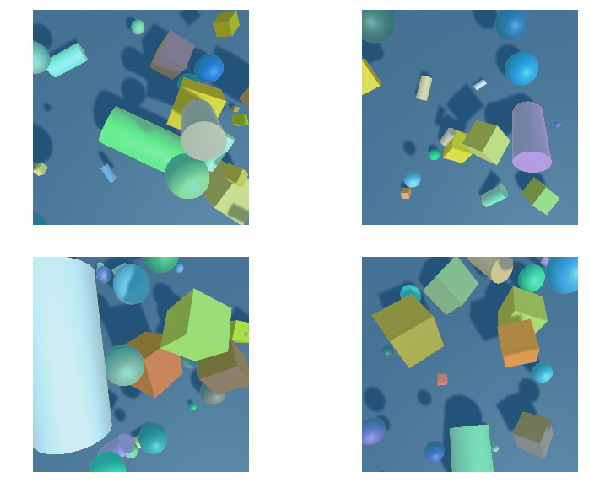

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['0']

def acc_segmentation(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_segmentation

In [19]:
wd=1e-2

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


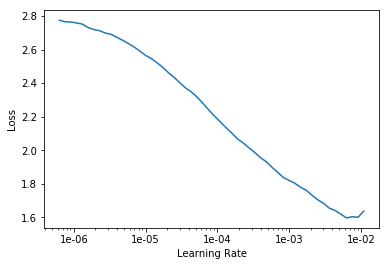

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
lr=1e-3

In [23]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_segmentation
1,0.330404,0.246984,0.824705
2,0.211014,0.207531,0.842854
3,0.158934,0.146594,0.885901
4,0.119160,0.114485,0.911623
5,0.114661,0.112698,0.913996
6,0.099054,0.094324,0.925116
7,0.105433,0.138526,0.913087
8,0.073155,0.104306,0.927891
9,0.063171,0.093384,0.931863
10,0.047001,0.073286,0.942126


In [24]:
learn.save('stage-1')

In [25]:
learn.load('stage-1');

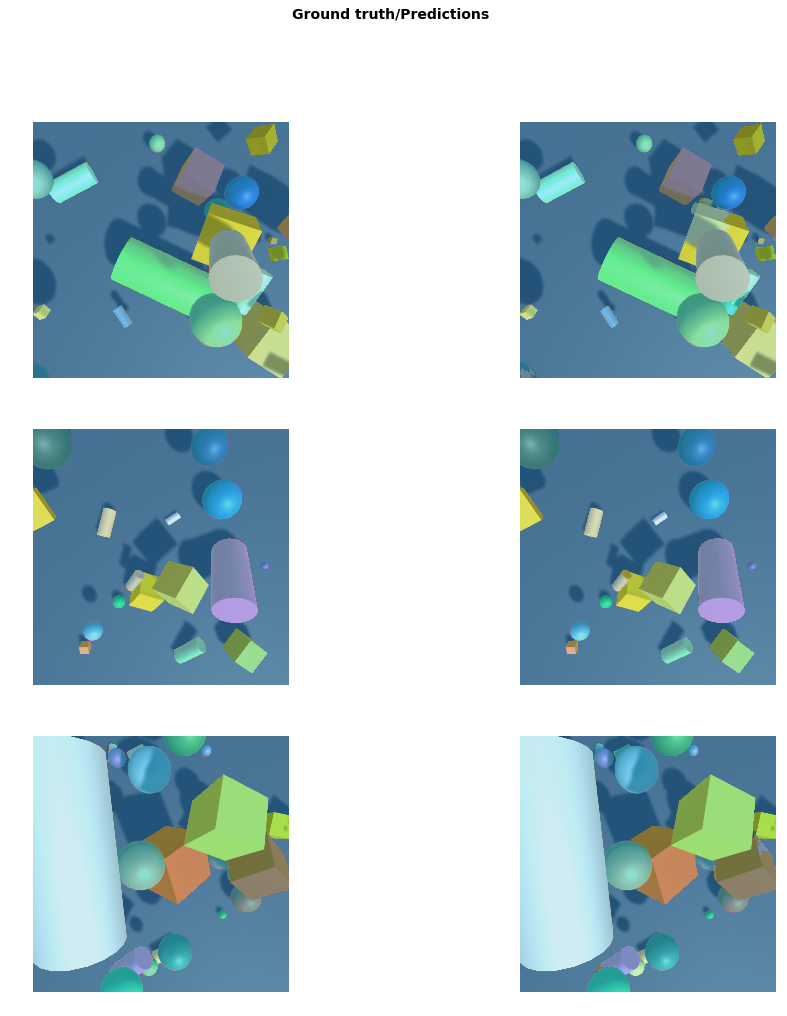

In [26]:
learn.show_results(rows=3, figsize=(16,16))

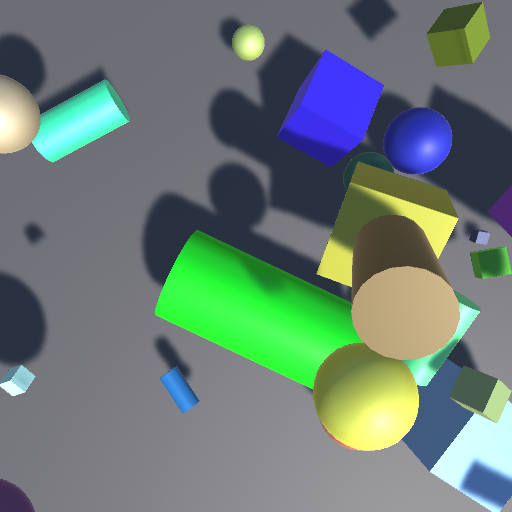

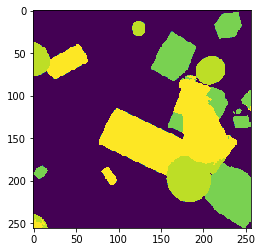

In [27]:
img = open_image((path/'val').ls()[0])
display(img)
plt.imshow(learn.predict(img)[1].squeeze())

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=3

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin